In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import zipfile
from keras import regularizers

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4ZMvgr9B4K6VemnFHCER6dGbnhlJlhh2lFcA1BpXPmH7DEeBAYxuM
Mounted at /content/drive


In [3]:
local_zip = "/content/drive/MyDrive/creditcard.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/credit_card")
zip_ref.close()

In [117]:
df = pd.read_csv("/credit_card/creditcard.csv")

**Balancing the data**

In [118]:
df[df.duplicated()]
df.drop_duplicates(inplace=True)

In [119]:
non_fraud=df[df["Class"]==0]
fraud = df[df["Class"]==1]
non_fraud.shape, fraud.shape

((283253, 31), (473, 31))

In [120]:
non_fraud=non_fraud.sample(fraud.shape[0])
non_fraud.shape

(473, 31)

In [121]:
data = fraud.append(non_fraud, ignore_index=True)
data.shape
data["Class"].value_counts()

1    473
0    473
Name: Class, dtype: int64

In [122]:
x_data= data.drop(columns=["Class", "Time"], axis=0)
label = data["Class"]

In [123]:
x_data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64

In [124]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      946 non-null    float64
 1   V2      946 non-null    float64
 2   V3      946 non-null    float64
 3   V4      946 non-null    float64
 4   V5      946 non-null    float64
 5   V6      946 non-null    float64
 6   V7      946 non-null    float64
 7   V8      946 non-null    float64
 8   V9      946 non-null    float64
 9   V10     946 non-null    float64
 10  V11     946 non-null    float64
 11  V12     946 non-null    float64
 12  V13     946 non-null    float64
 13  V14     946 non-null    float64
 14  V15     946 non-null    float64
 15  V16     946 non-null    float64
 16  V17     946 non-null    float64
 17  V18     946 non-null    float64
 18  V19     946 non-null    float64
 19  V20     946 non-null    float64
 20  V21     946 non-null    float64
 21  V22     946 non-null    float64
 22  V2

**Splitting Training and Test data**

In [125]:
x_data = data.sample(frac=1) # Shuffling the data
train_data_full= x_data.iloc[:662,:]
test_data_full = x_data.iloc[662:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1]

In [126]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(662, 30)
(284, 30)
(662,)
(284,)


**Normalizing the data**

In [127]:
mean = train_data.mean(axis=0)
train_data -=mean
std =train_data.std(axis=0)
train_data /=std

test_data -=mean
test_data /=std

In [128]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

**Building The Network**

In [129]:
def build_model():
  model= models.Sequential()
  model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dropout(.3))
  model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"))
  model.add(layers.Dropout(.3))
  model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"))
  model.add(layers.Dropout(.3))
  model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"))
  model.add(layers.Dropout(.3))
  model.add(layers.Dense(1,activation="sigmoid"))
  model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
  return model

**K Fold Validation**

In [130]:
k= 5
num_val_sample = len(train_data) // k
num_epochs = 100
all_scores = []
all_val_loss_histories = []
all_val_acc_histories = []
all_loss_histories =[]
all_acc_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, verbose=1)
  val_loss, val_acc = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_acc_history = history.history["val_accuracy"]
  loss_history = history.history["loss"]
  acc_history = history.history["accuracy"]
  all_loss_histories.append(loss_history)
  all_acc_histories.append(acc_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_acc_histories.append(val_acc_history)
  all_scores.append(val_acc)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_acc_hist = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
ave_acc_hist = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
print("All Accuracy values evaluated by teh Model are given below:")
all_scores

processing fold # 0
Epoch 1/100
17/17 [==============================] - 1s 21ms/step - loss: 0.8546 - accuracy: 0.5578 - val_loss: 0.7720 - val_accuracy: 0.6364
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.8346 - accuracy: 0.5768 - val_loss: 0.7541 - val_accuracy: 0.6970
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.8402 - accuracy: 0.5763 - val_loss: 0.7406 - val_accuracy: 0.8333
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.7878 - accuracy: 0.6638 - val_loss: 0.7254 - val_accuracy: 0.8409
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.8053 - accuracy: 0.6328 - val_loss: 0.7108 - val_accuracy: 0.8561
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.7771 - accuracy: 0.6652 - val_loss: 0.6912 - val_accuracy: 0.8561
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.7738 - accuracy: 0.6642 - val_loss: 0.6793 - val_accuracy:

[0.9366196990013123,
 0.9471830725669861,
 0.9366196990013123,
 0.9154929518699646,
 0.9295774698257446]

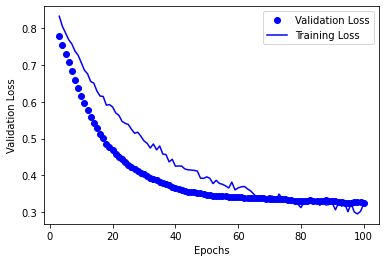

In [131]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_val_loss_hist[2:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_loss_hist[2:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

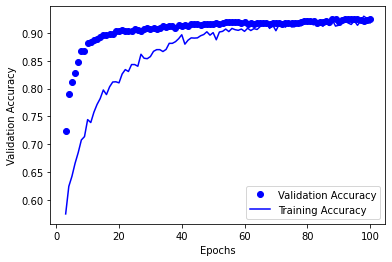

In [132]:
plt.plot(range(1, len(ave_val_acc_hist)+1)[2:], ave_val_acc_hist[2:], "bo", label="Validation Accuracy")
plt.plot(range(1, len(ave_val_acc_hist)+1)[2:], ave_acc_hist[2:], "b", label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

**Rebuilding the best fit Model**

In [134]:
model= models.Sequential()
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dropout(.3))
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"))
model.add(layers.Dropout(.3))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"))
model.add(layers.Dropout(.3))
model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"))
model.add(layers.Dropout(.3))
model.add(layers.Dense(1,activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

**Training the model with all samples**

In [136]:
model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
21/21 [==============================] - 1s 2ms/step - loss: 0.8693 - accuracy: 0.5151
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.8296 - accuracy: 0.5856
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.8248 - accuracy: 0.5971
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.7827 - accuracy: 0.6698
Epoch 5/100
21/21 [==============================] - 0s 1ms/step - loss: 0.7589 - accuracy: 0.7073
Epoch 6/100
21/21 [==============================] - 0s 1ms/step - loss: 0.7349 - accuracy: 0.7254
Epoch 7/100
21/21 [==============================] - 0s 1ms/step - loss: 0.7195 - accuracy: 0.7134
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.7047 - accuracy: 0.7590
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6679 - accuracy: 0.7884
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6403 - accuracy: 0.8001
Epoch 11/

**Evaluating the Network**

In [137]:
test_loss_score, test_acc_score=model.evaluate(test_data, test_labels)

9/9 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.9366


In [138]:
test_acc_score *100

93.66196990013123

**Predicting the values**

In [139]:
prediction=model.predict(test_data)
pred_norm =np.where(prediction>.5, 1, 0)
pred_norm[10:20].T

array([[1, 0, 0, 1, 0, 1, 1, 1, 0, 1]])

In [140]:
test_labels[10:20].astype(dtype="int")

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1])

In [141]:
pred_check =pred_norm[:].T.astype(dtype="int")

In [142]:
c = pred_check.size

In [143]:
comapre_pred_test = test_labels == pred_check

In [144]:
a = comapre_pred_test[comapre_pred_test[:]== False].size

In [145]:
b = comapre_pred_test[comapre_pred_test[:]==True].size

In [146]:
print("Incorrect Predictions are:", a, "and Correct predictions are :", b, " the percentage is:", round((b/c)*100,2), "%"  )

Incorrect Predictions are: 18 and Correct predictions are : 266  the percentage is: 93.66 %
